In [1]:
import torch
from data_utils import GuidedGridMLMDataset, GuidedGridMLM_collate_fn
from torch.utils.data import DataLoader
from GridMLM_tokenizers import GuidedGridMLMTokenizer
from models import GuidedMLMH
from tqdm import tqdm
import numpy as np

/home/maximos/miniconda3/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device_name = 'cuda:2'
val_dir = '/media/maindisk/data/hooktheory_hr/hooktheory_all12_test'
jazz_dir = '/media/maindisk/data/gjt_melodies/gjt'
subfolder = 'all12'
curriculum_type='random'
ablation = 'all'

In [3]:
model_path = 'saved_models/' + subfolder + '/' + curriculum_type + '_' + ablation + '.pt'
tokenizer = GuidedGridMLMTokenizer(fixed_length=256)
val_dataset = GuidedGridMLMDataset(val_dir, tokenizer, 512, frontloading=True)
jazz_dataset = GuidedGridMLMDataset(jazz_dir, tokenizer, 512, frontloading=True)

Loading data file.
Loading data file.


In [4]:
if device_name == 'cpu':
        device = torch.device('cpu')
else:
    if torch.cuda.is_available():
        device = torch.device(device_name)
    else:
        print('Selected device not available: ' + device_name)
vae_cfg = {
    'input_dim': 512,
    'hidden_dim': 256,
    'latent_dim': 128,
    'embedding_dim': 64,
    'seq_len': 256,
    'feature_dim': 37,
}
encoder_cfg = {
    'nhead': 8,
    'num_layers': 8,
    'stage_embedding_dim': 64,
    'max_stages': 10
}
model = GuidedMLMH(
    vae_cfg=vae_cfg,
    encoder_cfg=encoder_cfg,
    chord_vocab_size=len(tokenizer.vocab),
    d_model=512,
    conditioning_dim=16,
    pianoroll_dim=100,
    grid_length=256,
    guidance_dim=128,
    unfold_latent=True,
    device=device,
)
checkpoint = torch.load(model_path, map_location=device_name)
model.load_state_dict(checkpoint)
model.eval()
model.to(device)

GuidedMLMH(
  (condition_proj): Linear(in_features=16, out_features=512, bias=True)
  (melody_proj): Linear(in_features=100, out_features=512, bias=True)
  (harmony_embedding): Embedding(354, 512)
  (guidance_to_dmodel): Linear(in_features=128, out_features=512, bias=True)
  (vae): GuidanceVAE(
    (embedding): Embedding(354, 64)
    (encoder_rnn): LSTM(64, 256, batch_first=True)
    (mu_proj): Linear(in_features=256, out_features=128, bias=True)
    (logvar_proj): Linear(in_features=256, out_features=128, bias=True)
    (decoder_rnn): LSTM(128, 256, batch_first=True)
    (recon_proj): Linear(in_features=256, out_features=354, bias=True)
    (feature_proj): Linear(in_features=128, out_features=37, bias=True)
  )
  (encoder): GridMLMMelHarmEncoder(
    (stage_embedding): Embedding(10, 64)
    (stage_proj): Linear(in_features=576, out_features=512, bias=True)
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-7): 8 x TransformerEncoderLayer(
          (self_attn): 

In [5]:
zs = []
z_idxs = []
for d in tqdm(val_dataset):
    full_harmony = torch.tensor(d['input_ids']).reshape(1, len(d['input_ids']))
    z = model.get_z_from_harmony(full_harmony.to(device)).detach().cpu()[0].tolist()
    zs.append(z)
    z_idxs.append(0)
for d in tqdm(jazz_dataset):
    full_harmony = torch.tensor(d['input_ids']).reshape(1, len(d['input_ids']))
    z = model.get_z_from_harmony(full_harmony.to(device)).detach().cpu()[0].tolist()
    zs.append(z)
    z_idxs.append(0)

100%|██████████| 650/650 [00:02<00:00, 260.24it/s]


In [6]:
z_np = np.array( zs )
print(z_np.shape)

(2536, 128)


In [7]:
from sklearn.manifold import TSNE

In [8]:
z_tnse = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3, verbose=2).fit_transform(z_np)

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.


[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 2536 samples in 0.001s...


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

[t-SNE] Computed neighbors for 2536 samples in 2.349s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2536
[t-SNE] Computed conditional probabilities for sample 2000 / 2536
[t-SNE] Computed conditional probabilities for sample 2536 / 2536
[t-SNE] Mean sigma: 1.635301
[t-SNE] Computed conditional probabilities in 0.007s
[t-SNE] Iteration 50: error = 107.0570145, gradient norm = 0.0951978 (50 iterations in 0.237s)
[t-SNE] Iteration 100: error = 105.7076035, gradient norm = 0.2052544 (50 iterations in 0.266s)
[t-SNE] Iteration 150: error = 107.4664993, gradient norm = 0.0747752 (50 iterations in 0.240s)
[t-SNE] Iteration 200: error = 106.7396927, gradient norm = 0.0738486 (50 iterations in 0.214s)
[t-SNE] Iteration 250: error = 107.2734909, gradient norm = 0.0724446 (50 iterations in 0.203s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 107.273491
[t-SNE] Iteration 300: error = 4.3259254, gradient norm = 0.0346135 (50 iterations in 0.168s)
[t-SNE] Ite

In [9]:
print(z_tnse.shape)

(2536, 2)


In [10]:
import matplotlib.pyplot as plt

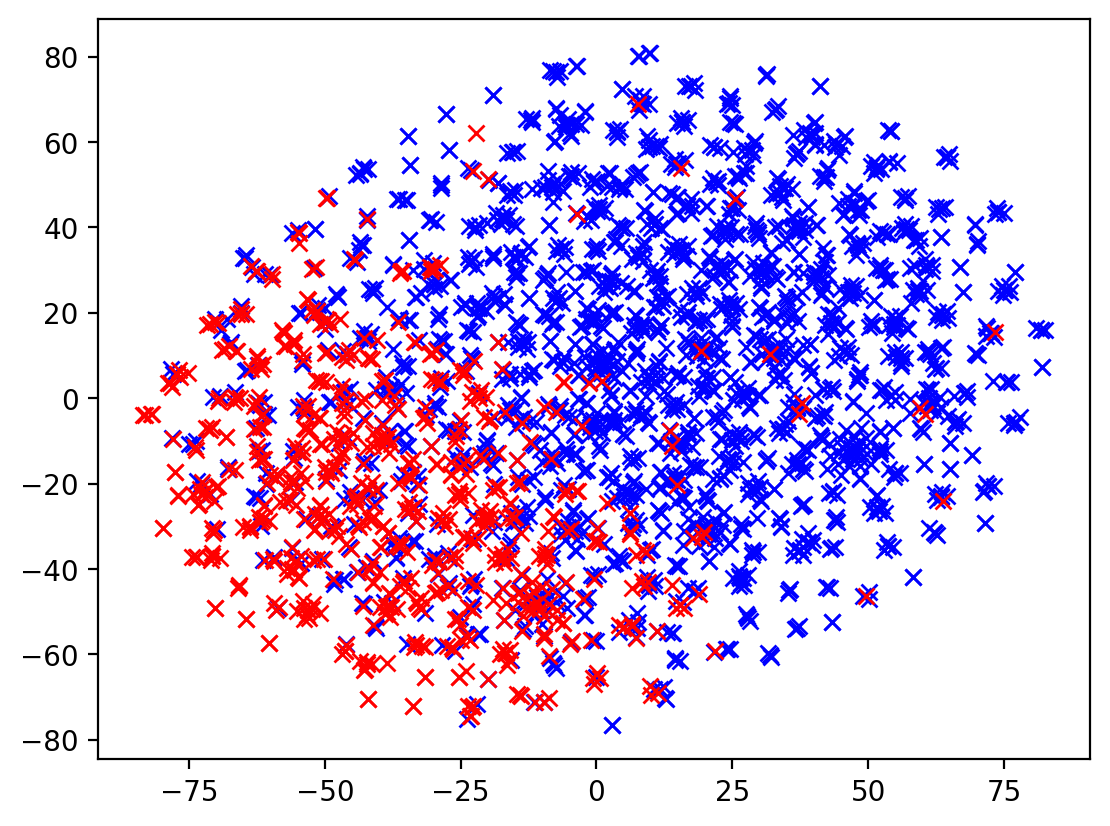

In [12]:
plt.plot(z_tnse[:len(val_dataset),0], z_tnse[:len(val_dataset),1], 'bx')
plt.plot(z_tnse[len(val_dataset):,0], z_tnse[len(val_dataset):,1], 'rx')